<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/Cluster_CA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install XlsxWriter
!pip install pingouin
from IPython.display import clear_output
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

clear_output()

In [2]:
plot_extras = True
exclude_extras =True

In [3]:
link = 'https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0'
xl_to_analyze = 'DG Type II GC main parameters.xlsx'

my_drop_folder = 'my_drop_folder'
zipped_file_path = "/content/"+my_drop_folder + ".zip"
unzipped_file_path = "/content/"+my_drop_folder
if not( os.path.exists(zipped_file_path)):
    !wget -O $zipped_file_path $link    # download with new name
!echo A | unzip $zipped_file_path -d $unzipped_file_path 
print(unzipped_file_path)
my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=None,sheet_name=None)
for k in my_df_dict.keys():
    print(k)



--2022-09-26 19:31:12--  https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a [following]
--2022-09-26 19:31:12--  https://www.dropbox.com/sh/raw/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09f189a700ab30e07e4581c6dc.dl.dropboxusercontent.com/zip_download_get/BREELlM0-B2ukS377jZo2GKTL7gElUHrv6MM9S8swDwVbeiDjPxm5y6oyLOLPqKtmy6d6w6pCE8MWhZrEhW9ueo8nfierRlQhEa_XYnL6XWDtA# [following]
--2022-09-26 19:31:13--  https://uc09f189a700ab30e07e4581c6dc.dl.dropboxusercontent.com/zip_download_get/BREELlM0-B2ukS377jZo2GKTL7gElUHrv6MM9S8swDwVbeiDjPxm5y6oyLOLPqKtmy6d6w6pCE8MWhZrEhW9ueo8nfie

In [4]:
for k in my_df_dict.keys():
    df = my_df_dict[k]
    df['type'] = k
df_list = [my_df_dict[k] for k in my_df_dict.keys()]
full_df = pd.concat(df_list,ignore_index=True)
display(full_df.head())
# if 'cell' in full_df.columns:
#     full_df = full_df.set_index('cell')
# display(full_df.head())

,Cm,Rin,RMP,I-F Gain,Rheobase,Spike Latency,Max Firing rate,AP threshold,fAHP(1),sAHP,AP width,AP amp,Adaptation Ratio,AP rise time,type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E3 Type II 9mo
1,65.21,261.5818,-83.0,0.148571,100.0,165.101,32.0,-41.8427,7.469209,1.36861,0.704635,78.433281,6.505882,0.454012,E3 Type II 9mo
2,98.65,235.4657,-74.2,0.151429,80.0,212.842,35.0,-40.2224,6.970805,1.53944,0.734884,82.458702,9.500000,0.436424,E3 Type II 9mo
3,67.40,274.5377,-78.9,0.222857,80.0,151.122,42.0,-40.0381,7.665469,1.32858,0.738194,78.490227,8.220589,0.536071,E3 Type II 9mo
4,62.19,329.8902,-76.6,0.208571,70.0,174.982,48.0,-35.4362,8.720448,4.32937,0.785955,71.019661,2.401914,0.485473,E3 Type II 9mo


In [5]:
for r in full_df.index:
    if full_df.loc[r,'AP amp'] <60:
        full_df.at[r,'AP amp'] = np.nan

In [6]:
if 'extras' not in full_df.columns:
    exclude_extras = False
    plot_extras = False

In [7]:
full_df.columns

Index(['Cm', 'Rin', 'RMP', 'I-F Gain', 'Rheobase', 'Spike Latency',
       'Max Firing rate', 'AP threshold', 'fAHP(1)', 'sAHP', 'AP width',
       'AP amp', 'Adaptation Ratio', 'AP rise time', 'type'],
      dtype='object')

In [8]:
labeling = ['cell','Cell','type','extra'] # non numerical data 
numericals = [c for c in full_df.columns if c not in labeling ]


full_df_norm = full_df.copy()
mean_dict = {}
sd_dict = {}

for c in full_df_norm.columns:
    if c not in labeling:
        col_mean = np.mean(full_df_norm[c])
        col_sd = np.std(full_df_norm[c])
        mean_dict[c] = col_mean
        sd_dict[c] = col_sd
        full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


null_check = pd.isna(full_df_norm)
incomplete =[]
for r in full_df_norm.index:
    vals = np.array(null_check.loc[r,numericals])
    bad = any(vals)
    if bad:
        incomplete.append(r)
# print(incomplete)

complete = [c for c in  full_df_norm.index if c not in incomplete]
full_df_no_null = full_df_norm.loc[complete].copy()


if exclude_extras:
    is_extra = list(full_df_no_null['extra']==1)
    extra_ind = full_df_no_null.index[is_extra]
    full_df_no_null.drop( index =extra_ind, inplace=True)


data_X = full_df_no_null[numericals].to_numpy()
data_X.shape

display(full_df_no_null.head())
print('data_X.shape',data_X.shape)
data_for_fit = data_X
numericals = [n.replace('(1)', '') for n in numericals]

,Cm,Rin,RMP,I-F Gain,Rheobase,Spike Latency,Max Firing rate,AP threshold,fAHP(1),sAHP,AP width,AP amp,Adaptation Ratio,AP rise time,type
1,0.147117,-0.708629,-0.409934,-0.309267,1.290432,-0.269613,-0.464034,-1.215153,-0.646760,-0.711861,0.028332,0.377237,0.283593,-1.156846,E3 Type II 9mo
2,2.481246,-1.096849,1.405664,-0.264604,0.503360,0.830537,-0.282639,-0.782798,-0.861434,-0.597673,0.459338,1.130687,0.879477,-1.608187,E3 Type II 9mo
3,0.299980,-0.516038,0.435969,0.851978,0.503360,-0.591748,0.140616,-0.733620,-0.562226,-0.738618,0.506500,0.387896,0.624851,0.948993,E3 Type II 9mo
4,-0.063681,0.306784,0.910501,0.628662,0.109824,-0.041914,0.503406,0.494335,-0.107821,1.267199,1.186999,-1.010392,-0.533173,-0.349484,E3 Type II 9mo
5,3.035463,-1.437874,0.621656,0.137366,0.503360,-0.092151,0.201081,-1.126750,-1.961347,-0.985917,2.519524,-0.815761,1.520317,0.086462,E3 Type II 9mo


data_X.shape (82, 14)


In [9]:


type_list = list(full_df_no_null['type'])
uniq_types = list(set(type_list))
uniq_types.sort()
print(uniq_types)
num_t = len(uniq_types)
type_num = [ uniq_types.index(t) for t in type_list]

colors = plt.cm.viridis(np.linspace(0,1,num_t))
alpha = .2
colors = [[0, 0, 0, 1], [0, 0, 0, alpha],
          [1, 0, 1, 1], [1, 0, 1, alpha], 
          [0, .8, .8, 1], [0, .8, .8, alpha]]

alpha = 0
colors = [[0, 0, 1, 1], [0, 0, 1, alpha],
          [1, 0, 0, 1], [1, 0, 0, alpha], 
          [0, 0.5, 0, 1], [0, 0.5, 0, alpha]]

list_colors = [colors[i] for i in type_num ]

fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}

['E3 Type II 19mo', 'E3 Type II 9mo', 'E4 Type II 19mo', 'E4 Type II 9mo']


random_state 40


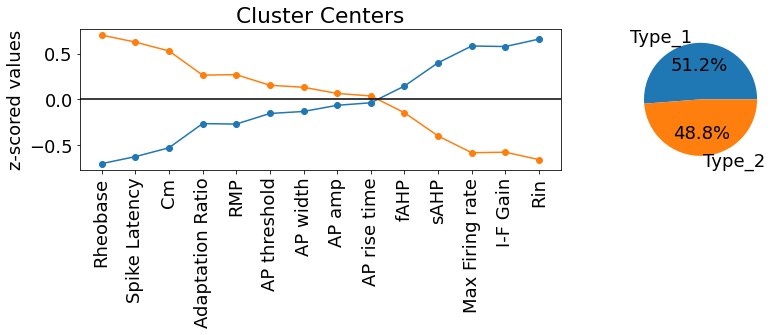

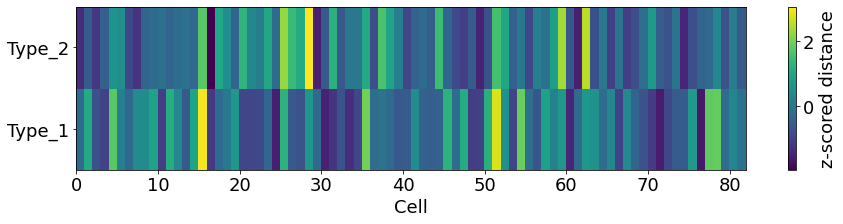

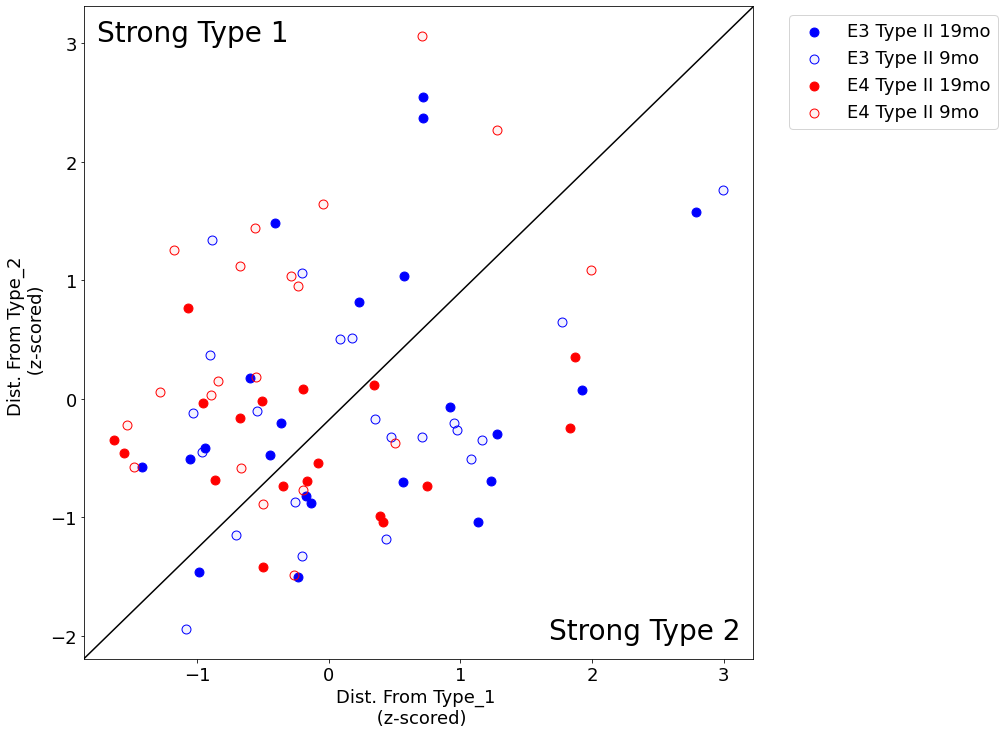

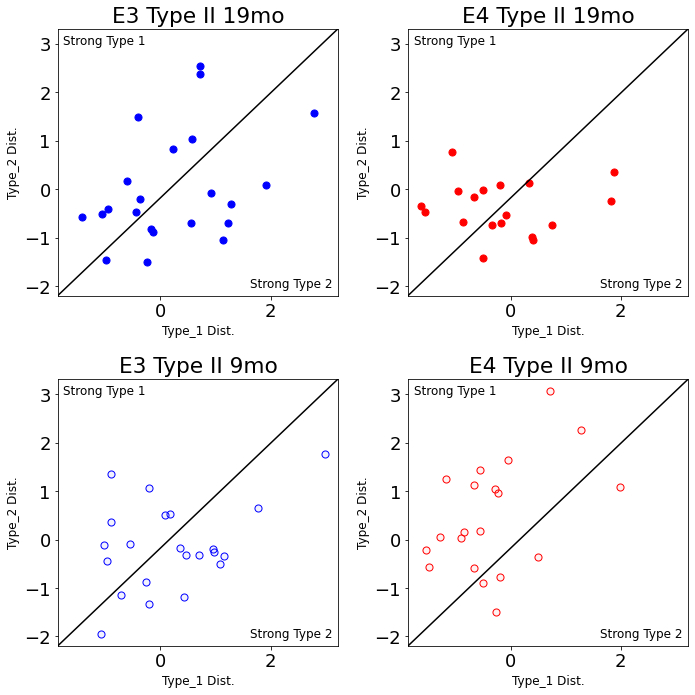

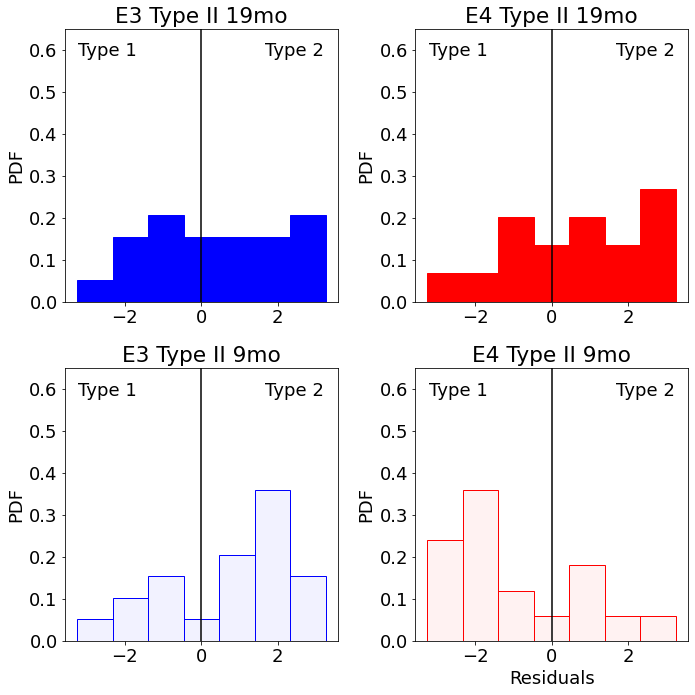

In [10]:

plt.rcParams.update({'font.size': 18})

plt.show()


colors = plt.cm.viridis(np.linspace(0,1,num_t))
alpha = .05
colors = [[0, 0, 1, 1], [0, 0, 1, alpha],
          [1, 0, 0, 1], [1, 0, 0, alpha], 
          [0, 0.5, 0, 1], [0, 0.5, 0, alpha]]

list_colors = [colors[i] for i in type_num ]

random_state = 42
if 'CA1' in xl_to_analyze:
    random_state = 40
    print('random_state',random_state)
if 'Type I ' in xl_to_analyze:
    random_state = 41
    print('random_state',random_state)
if 'Type II ' in xl_to_analyze:
    random_state = 40
    print('random_state',random_state)



from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=random_state).fit(data_for_fit)
centers = kmeans.cluster_centers_.T
distances = kmeans.transform(data_for_fit)

rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T
################# Pie Chart and Centers
new_cent_order = np.argsort(centers[:,0]).tolist()
fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
ax[0].plot(rel_centers[new_cent_order,:],'-o')
# ax[0].legend(['Type_1', 'Type_2'])
sorted_numericals = [numericals[i] for i in new_cent_order]
ax[0].set_xticks(np.arange(len(numericals)))
ax[0].set_xticklabels(sorted_numericals,rotation=90)
ax[0].set_ylabel('z-scored values') 
ax[0].axhline(0,color='k')
ax[0].title.set_text('Cluster Centers')
labels = kmeans.labels_ 
rel_counts = [np.mean( l == labels ) for l in range(2)]
# print(counts)
ax[1].pie( rel_counts, labels=['Type_1 ', 'Type_2 '],autopct='%1.1f%%' )
plt.rcParams.update({'font.size': 18})
plt.tight_layout()



################# Distance heat map
total_D = np.tile(np.sum(distances,axis=1),[2,1]).T
closeness = np.log(total_D/distances)
closeness = (closeness - np.mean(closeness,axis=0)) / (np.std(closeness,axis=0))  
distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))
score = closeness[:,1] - closeness[:,0]


fig_distances, ax = plt.subplots(1,figsize = [15,3])
c = ax.pcolor(distances_norm.T)
ax.set_xlabel('Cell')
ax.set_yticks(np.arange(2)+0.5)
ax.set_yticklabels(['Type_1', 'Type_2'])
# ax.title.set_text('Distance')
fig_distances.colorbar(c, ax=ax,label='z-scored distance')
fig_distances.savefig('Cells_in_Clusters.'+fig_opt['format'],**fig_opt)


############# Combined Scatter
fig_comb_scatter, ax = plt.subplots(1,figsize = [12,12])
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]    
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=80)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Dist. From Type_1 \n (z-scored)')
ax.set_ylabel('Dist. From Type_2 \n (z-scored)')
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k')
ax.text(0.98, 0.02, 'Strong Type 2',transform=ax.transAxes,ha='right',va='bottom',fontsize=28)
ax.text(0.02, 0.98, 'Strong Type 1',transform=ax.transAxes,ha='left',va='top',fontsize=28)

comb_xlim = ax.get_xlim()
comb_ylim = ax.get_ylim()

#### separate #####
fig_sep_scatter, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=50)
    # axs[ti].set_xlabel('Dist. From Type_1')
    # axs[ti].set_ylabel('Dist. From Type_2')
    axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
    axs[ti].title.set_text(t)
    axs[ti].set_xlim(comb_xlim)
    axs[ti].set_ylim(comb_ylim)


    axs[ti].set_xlabel('Type_1 Dist.',fontsize=12)
    axs[ti].set_ylabel('Type_2 Dist.',fontsize=12)
    axs[ti].text(0.98, 0.02, 'Strong Type 2',transform=axs[ti].transAxes,ha='right',va='bottom',fontsize=12)
    axs[ti].text(0.02, 0.98, 'Strong Type 1',transform=axs[ti].transAxes,ha='left',va='top',fontsize=12)

    if plot_extras:
        is_extra = list(full_df_no_null['extra']==1)
        is_extra_ind = [i for i in range(len(is_extra)) if is_extra[i] ]
        both = [i for i in is_type if i in is_extra_ind]
        axs[ti].scatter(distances_norm[both,0],distances_norm[both,1],color=t_colr,
                         label=t,marker='x',s=400,linewidths=3,edgecolors=t_colr_edge)
plt.rcParams.update({'font.size': 18})
plt.tight_layout()





#### separate #####
fig_sep_hist, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    # score = closeness[:,1] - closeness[:,0]

    axs[ti].hist(score[is_type],7,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25),edgecolor=t_colr_edge)
    axs[ti].title.set_text(t)
    axs[ti].axvline(0, color='k') # vertical
    axs[ti].set_ylim(0,0.65)
    axs[ti].set_ylabel('PDF')
    axs[ti].text(.95, .9, 'Type 2',transform=axs[ti].transAxes,ha='right')
    axs[ti].text(.05, .9, 'Type 1',transform=axs[ti].transAxes,ha='left')

    if plot_extras:
        is_extra = list(full_df_no_null['extra']==1)
        is_extra_ind = [i for i in range(len(is_extra)) if is_extra[i] ]
        both = [i for i in is_type if i in is_extra_ind]
        axs[ti].hist(score[both],10,color=t_colr,histtype='step',density=True,range=(-3.25,3.25))

axs[3].set_xlabel('Residuals')
plt.tight_layout()


fig_clust_pie.savefig('Clusters.'+fig_opt['format'],**fig_opt)
fig_sep_scatter.savefig('GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
fig_comb_scatter.savefig('GenoType_dist.'+fig_opt['format'],**fig_opt)
fig_sep_hist.savefig('GenoType_Histos.'+fig_opt['format'],**fig_opt)

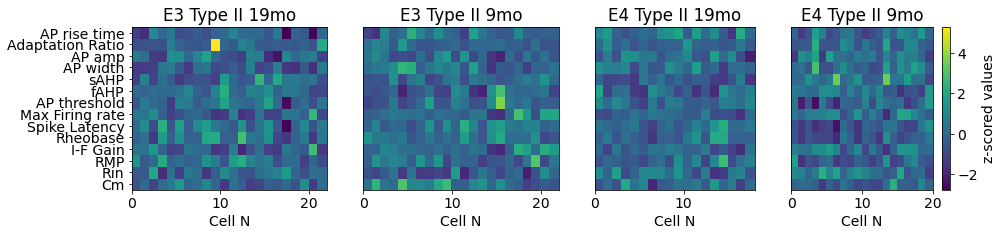

In [11]:
### raw_data_map 
plt.rcParams.update({'font.size': 14})
counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
fig, ax = plt.subplots(1,num_t,figsize = [15,3],gridspec_kw={'width_ratios': counts})


data_X_min = np.min(data_for_fit)
data_X_max = np.max(data_for_fit)

for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min, vmax=data_X_max)
    ax[ti].set_yticks(np.arange(len(numericals))+0.5)
    if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
    else:  ax[ti].get_yaxis().set_visible(False)
    ax[ti].set_xlabel('Cell N')
    ax[ti].title.set_text(t)

    start = min(is_type)+3 / len(is_type)
    stop = max(is_type)-3 / len(is_type)

    
plt.colorbar(c, ax=ax[ti],label='z-scored values')
plt.show()
fig.savefig('Normalized_Vals_split.'+fig_opt['format'],**fig_opt)



In [12]:
is_E3 = ['E3' in t for t in type_list ]
is_9mo = [' 9' in t for t in type_list ]
age_list = [9 if b else 19 for b in is_9mo]
genotype = ['E3' if b else 'E4' for b in is_E3]
is_crePos = ['cre+' in t for t in type_list ]
is_creNeg = ['cre-' in t for t in type_list ]
not_cree = [not any( [is_crePos[i], is_creNeg[i]] ) for i in range(len(is_crePos))]
e34_genotype = [genotype[i] for i in range(len(not_cree)) if not_cree[i]]
e34_score = [score[i] for i in range(len(not_cree)) if not_cree[i]]
e34_age = [str(age_list[i])+'mo' for i in range(len(not_cree)) if not_cree[i]]
genotype_list_str = [t.replace(' 9mo', '').replace(' 19mo', '') for t in type_list]
age_list_str = [str(a)+'mo' for a in age_list]


df_for_34_2W_anova =  pd.DataFrame({'genotype': genotype_list_str,  'Age': age_list_str,'T1_Score': score})

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pingouin as pg
ANOVA2_results = pg.anova(dv='T1_Score', between=['genotype', 'Age'], data=df_for_34_2W_anova, detailed=True)
display(ANOVA2_results)
ANOVA2_results.to_csv('2W_results Age-Geno.csv')

df_for_34_2W_anova['combination'] = df_for_34_2W_anova.genotype + " : " + df_for_34_2W_anova.Age
m_comp = pairwise_tukeyhsd(endog=df_for_34_2W_anova['T1_Score'], groups=df_for_34_2W_anova['combination'], alpha=0.05)
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_data = tukey_data.sort_values('p-adj',ascending=True)
display(tukey_data)
tukey_data.to_csv('pairwise Age-Genotype.csv')

,Source,SS,DF,MS,F,p-unc,np2
0,genotype,23.326835,1.0,23.326835,6.444579,0.013120,0.076317
1,Age,6.933440,1.0,6.933440,1.915524,0.170298,0.023969
2,genotype * Age,12.351638,1.0,12.351638,3.412426,0.068499,0.041915
3,Residual,282.329230,78.0,3.619606,NaN,NaN,NaN


,group1,group2,meandiff,p-adj,lower,upper,reject
4,E3 Type II : 9mo,E4 Type II : 9mo,-1.8268,0.0137,-3.3700,-0.2837,True
2,E3 Type II : 19mo,E4 Type II : 9mo,-1.6879,0.0265,-3.2311,-0.1448,True
5,E4 Type II : 19mo,E4 Type II : 9mo,-1.4189,0.1079,-3.0416,0.2038,False
3,E3 Type II : 9mo,E4 Type II : 19mo,-0.4079,0.9064,-1.9953,1.1795,False
1,E3 Type II : 19mo,E4 Type II : 19mo,-0.2690,0.9704,-1.8565,1.3184,False
0,E3 Type II : 19mo,E3 Type II : 9mo,0.1389,0.9950,-1.3671,1.6448,False


100%|██████████| 1000/1000 [00:35<00:00, 28.53it/s]


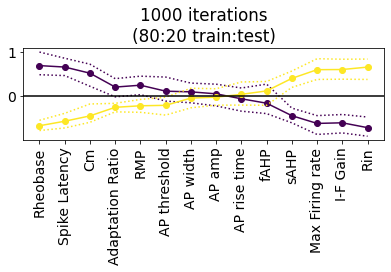

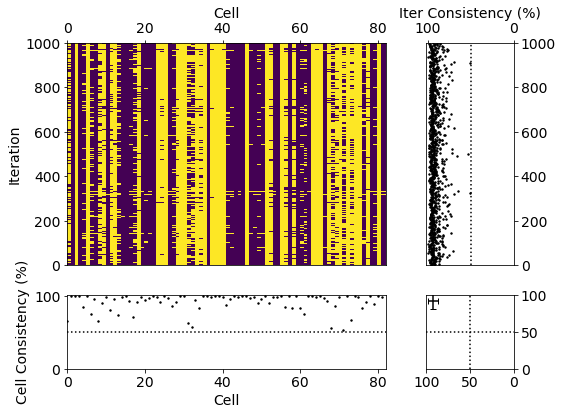

In [13]:
from pandas.compat.numpy import np_array_datetime64_compat
###########   Cluster Validation #############
from random import sample
from tqdm import tqdm
import scipy
''' random sub sample cluster and plot cluster center similarity '''
SubSampleFrac = .8
num_iter = 1000
center_list = []
label_list = []
sub_sample_ind_list = []
full_label_list = []
k = 2
plt.rcParams.update({'font.size': 14})
pred_all = True

for ni in tqdm( range(num_iter) ):
    sub_sample_ind = []
    for t in uniq_types:
        t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
        # print(t_inds)
        sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
    kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
    centers_iter = kmeans_iter.cluster_centers_.T
    centers_iter = centers_iter - np.mean(centers_iter,axis=0)
    labels_iter = kmeans_iter.labels_
    if pred_all:
        labels_iter = kmeans_iter.predict(data_for_fit)

    if ni>0:
        corco = np.corrcoef(centers_iter.T,center_list[0].T)
        corco = corco[0:k,k:]
        ind = np.argmax(corco,axis=0) 
        centers_iter = centers_iter[:,ind]
        labels_iter = [ind[l] for l in labels_iter]
    
    if not pred_all:
        full_label_iter = np.empty((data_for_fit.shape[0],))
        full_label_iter[:] = np.nan
        full_label_iter[sub_sample_ind] = labels_iter
    else:
        full_label_iter = labels_iter

    center_list.append(centers_iter)
    label_list.append(labels_iter)
    sub_sample_ind_list.append(sub_sample_ind_list)
    full_label_list.append(full_label_iter)
   
center_stack = np.stack(center_list)
mean_center = np.mean(center_stack,0)
nintey_p_center = np.percentile(center_stack, [2.5, 97.5], axis=0)

cmap = plt.cm.viridis(np.linspace(0,1,k))
fig_cv_cent, ax = plt.subplots(1)
for ki in range(k):
    ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki])
    ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki])
    ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki])


ax.set_xticks(np.arange(len(numericals)))
ax.set_xticklabels(sorted_numericals,rotation=90)
ax.axhline(0, color='k')



full_label_stack = np.stack(full_label_list)

pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
is_match[np.isnan(full_label_stack)]=np.nan
consistency_iter = np.nanmean(is_match, axis = 1)
mean_consistency_iter = np.nanmean(consistency_iter)
std_consistency_iter = np.nanstd(consistency_iter)
consistency_cell = np.nanmean(is_match, axis = 0)
mean_consistency_cell = np.nanmean(consistency_cell)
sd_consistency_cell = np.nanstd(consistency_cell)
consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
# print(consistency_report)
# print('(chance: ' + str(round(1/k*100,1))+')')
ax.title.set_text(f'{num_iter} iterations\n(80:20 train:test)' )

# plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()
fig_cv_cent.savefig(f'CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

fig_cv_prob, ax = plt.subplots(2,2,figsize=[8,6], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
ax  = ax.T.flatten()
ax[0].pcolor( full_label_stack )
ax[0].set_xlabel('Cell')
ax[0].set_ylabel('Iteration')
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()

ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
ax[1].axhline(1/k*100,color='k',linestyle=':')
ax[1].set_ylabel('Cell Consistency (%)')
ax[1].set_ylim((0,102))
ax[1].set_xlim((0,is_match.shape[1]))
ax[1].set_xlabel('Cell')


ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
ax[2].axvline(1/k*100,color='k',linestyle=':')
ax[2].set_xlabel('Iter Consistency (%)')
ax[2].set_xlim((102,0))
ax[2].set_ylim((0,num_iter))
ax[2].yaxis.tick_right()
ax[2].xaxis.set_label_position('top') 
ax[2].xaxis.tick_top()

# fig.delaxes(ax[3])
ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100, yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
ax[3].axvline(1/k*100,color='k',linestyle=':')
ax[3].axhline(1/k*100,color='k',linestyle=':')
ax[3].set_xlim((100,0))
ax[3].set_ylim((0,100))
ax[3].yaxis.tick_right()

# plt.rcParams.update({'font.size': 18})
# 
# plt.show()
# plt.tight_layout()
fig_cv_prob.savefig(f'CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)

100%|██████████| 1000/1000 [00:24<00:00, 41.50it/s]


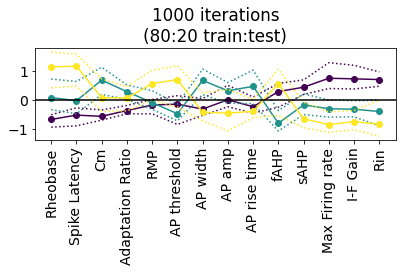

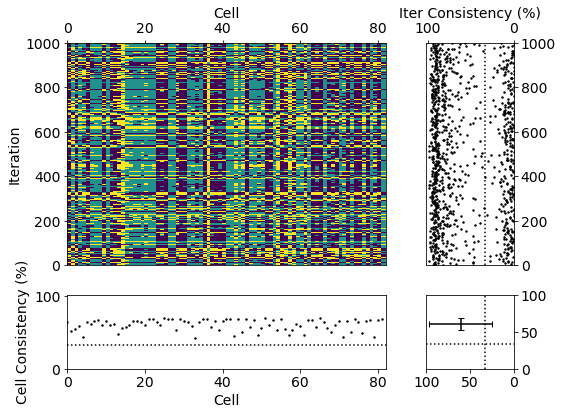

In [14]:
from pandas.compat.numpy import np_array_datetime64_compat
###########   Cluster Validation #############
from random import sample
from tqdm import tqdm
import scipy
''' random sub sample cluster and plot cluster center similarity '''
SubSampleFrac = .8
num_iter = 1000
center_list = []
label_list = []
sub_sample_ind_list = []
full_label_list = []
k = 3
plt.rcParams.update({'font.size': 14})
pred_all = True

for ni in tqdm( range(num_iter) ):
    sub_sample_ind = []
    for t in uniq_types:
        t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
        # print(t_inds)
        sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
    kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
    centers_iter = kmeans_iter.cluster_centers_.T
    centers_iter = centers_iter - np.mean(centers_iter,axis=0)
    labels_iter = kmeans_iter.labels_
    if pred_all:
        labels_iter = kmeans_iter.predict(data_for_fit)

    if ni>0:
        corco = np.corrcoef(centers_iter.T,center_list[0].T)
        corco = corco[0:k,k:]
        ind = np.argmax(corco,axis=0) 
        centers_iter = centers_iter[:,ind]
        labels_iter = [ind[l] for l in labels_iter]
    
    if not pred_all:
        full_label_iter = np.empty((data_for_fit.shape[0],))
        full_label_iter[:] = np.nan
        full_label_iter[sub_sample_ind] = labels_iter
    else:
        full_label_iter = labels_iter

    center_list.append(centers_iter)
    label_list.append(labels_iter)
    sub_sample_ind_list.append(sub_sample_ind_list)
    full_label_list.append(full_label_iter)
   
center_stack = np.stack(center_list)
mean_center = np.mean(center_stack,0)
nintey_p_center = np.percentile(center_stack, [2.5, 97.5], axis=0)

cmap = plt.cm.viridis(np.linspace(0,1,k))
fig_cv_cent, ax = plt.subplots(1)
for ki in range(k):
    ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki])
    ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki])
    ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki])


ax.set_xticks(np.arange(len(numericals)))
ax.set_xticklabels(sorted_numericals,rotation=90)
ax.axhline(0, color='k')



full_label_stack = np.stack(full_label_list)

pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
is_match[np.isnan(full_label_stack)]=np.nan
consistency_iter = np.nanmean(is_match, axis = 1)
mean_consistency_iter = np.nanmean(consistency_iter)
std_consistency_iter = np.nanstd(consistency_iter)
consistency_cell = np.nanmean(is_match, axis = 0)
mean_consistency_cell = np.nanmean(consistency_cell)
sd_consistency_cell = np.nanstd(consistency_cell)
consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
# print(consistency_report)
# print('(chance: ' + str(round(1/k*100,1))+')')
ax.title.set_text(f'{num_iter} iterations\n(80:20 train:test)' )

# plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()
fig_cv_cent.savefig(f'CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

fig_cv_prob, ax = plt.subplots(2,2,figsize=[8,6], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
ax  = ax.T.flatten()
ax[0].pcolor( full_label_stack )
ax[0].set_xlabel('Cell')
ax[0].set_ylabel('Iteration')
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()

ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
ax[1].axhline(1/k*100,color='k',linestyle=':')
ax[1].set_ylabel('Cell Consistency (%)')
ax[1].set_ylim((0,102))
ax[1].set_xlim((0,is_match.shape[1]))
ax[1].set_xlabel('Cell')


ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
ax[2].axvline(1/k*100,color='k',linestyle=':')
ax[2].set_xlabel('Iter Consistency (%)')
ax[2].set_xlim((102,0))
ax[2].set_ylim((0,num_iter))
ax[2].yaxis.tick_right()
ax[2].xaxis.set_label_position('top') 
ax[2].xaxis.tick_top()

# fig.delaxes(ax[3])
ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100, yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
ax[3].axvline(1/k*100,color='k',linestyle=':')
ax[3].axhline(1/k*100,color='k',linestyle=':')
ax[3].set_xlim((100,0))
ax[3].set_ylim((0,100))
ax[3].yaxis.tick_right()

# plt.rcParams.update({'font.size': 18})
# 
# plt.show()
# plt.tight_layout()
fig_cv_prob.savefig(f'CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)

In [15]:
root_list = []
f_list = []
import os
import shutil
# try: shutil.rmtree("/content/Results")
# except: None
# try: os.mkdir("/content/Results")
# except: None
# try: os.remove("Results.zip")
# except: None

fold_name = 'Results_' + xl_to_analyze.split('.')[0]
fold_name = fold_name.replace(' ','_')
zip_name= fold_name+'.zip'
try: os.mkdir(fold_name)
except: None

from google import colab
for root, dirs, files in os.walk("/content"):
    for f in files:
        if 'sample_data' in root: continue
        if 'Results' in root: continue
        if f.endswith(".png") or f.endswith(".csv"):
            shutil.copyfile(os.path.join(root,f), os.path.join(root,fold_name,f))

!zip -r $zip_name $fold_name
colab.files.download(zip_name)

  adding: Results_DG_Type_II_GC_main_parameters/ (stored 0%)
  adding: Results_DG_Type_II_GC_main_parameters/CrossVal_Data k=2 Centers.png (deflated 7%)
  adding: Results_DG_Type_II_GC_main_parameters/pairwise Age-Genotype.csv (deflated 55%)
  adding: Results_DG_Type_II_GC_main_parameters/2W_results Age-Geno.csv (deflated 43%)
  adding: Results_DG_Type_II_GC_main_parameters/CrossVal_Data k=3 Centers.png (deflated 5%)
  adding: Results_DG_Type_II_GC_main_parameters/GenoType_dist_Separate.png (deflated 18%)
  adding: Results_DG_Type_II_GC_main_parameters/Cells_in_Clusters.png (deflated 24%)
  adding: Results_DG_Type_II_GC_main_parameters/GenoType_Histos.png (deflated 27%)
  adding: Results_DG_Type_II_GC_main_parameters/Normalized_Vals_split.png (deflated 18%)
  adding: Results_DG_Type_II_GC_main_parameters/CrossVal_Data k=3 Labeling.png (deflated 9%)
  adding: Results_DG_Type_II_GC_main_parameters/CrossVal_Data k=2 Labeling.png (deflated 13%)
  adding: Results_DG_Type_II_GC_main_paramete

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
##### Importance Test
num_rep = 10
scram_space = data_for_fit.copy()
# for ni in range(len(numericasl)):
#     n = numericals[ni]
#     for rep in range(num_rep):
#         scram_space = data_for_fit.copy()
        
#         kmeans.predict()
